In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder

In [2]:
CLN_DATA_PATH='../data/codon_df_clean.csv'

try:
    codon_df_clean = pd.read_csv(CLN_DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: The data file does not exist.")

Data loaded successfully.


## Introduction


In this notebook, we will explore and compare several machine learning models for classifying codon frequencies into different biological kingdoms. Codons, which are sequences of three nucleotides, play a critical role in the genetic coding of proteins. The frequency of these codons can provide valuable insights into the biological origins of different species.

The primary objective of this study is to evaluate the performance of various machine learning algorithms in accurately classifying rows of codon frequencies into their respective biological kingdoms. We aim to determine which model offers the best performance in terms of accuracy, recall, and overall score.

In [3]:
#label encoder as an alternative to group de kingdoms
#kingdom_mapped = ['vrl', 'arc', 'bct', 'phg', 'plm', 'pln', 'inv', 'vrt', 'mam', 'rod', 'pri' ]
#label_encoder = LabelEncoder()

#codon_df_clean['Kingdom_labels'] = label_encoder.fit_transform(codon_df_clean['Kingdom'])
#codon_df_clean[['Kingdom_labels','Kingdom']].value_counts()


In [4]:
#separate the kingdoms into five, this is closer to the biological kingdoms
codon_df_clean['Kingdom'] = codon_df_clean['Kingdom'].replace({
    'vrl': 'virus_bacteriophage',
    'phg': 'virus_bacteriophage',
    'vrt': 'animalia',
    'pln': 'plantae',
    'bct': 'bacteria',
    'arc': 'archaea',
    'inv': 'animalia',
    'mam': 'animalia',
    'rod': 'animalia',
    'pri': 'animalia'
})


In [5]:
codon_df_clean = codon_df_clean[codon_df_clean['Kingdom'] != 'plm']

## Bayes model 


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
# Drop non-feature columns from the dataframe to create the feature set X
# The columns 'Kingdom_labels', 'SpeciesName', 'Kingdom', and 'SpeciesID' are removed
X = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'Kingdom', 'SpeciesID'])

# Extract the target variable 'Kingdom_labels' to create the label set y
y= codon_df_clean['Kingdom']

# Split the data into training and testing sets
# 20% of the data is reserved for testing, and the rest is used for training
# The random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [8]:
# Initialize the StandardScaler, which will standardize the features by removing the mean and scaling to unit variance
scaler_GNB = StandardScaler()

# Fit the scaler on the training data (learn the scaling parameters)
scaler_GNB.fit(X_train)

# Transform the training and test data using the fitted scaler
X_train_scaled = scaler_GNB.transform(X_train)
X_test_scaled = scaler_GNB.transform(X_test)

In [9]:
# Initialize the Gaussian Naive Bayes classifier
bayes = GaussianNB()

# Fit the Naive Bayes model on the scaled training data
bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [10]:
print(f'Accuracy on train set: {bayes.score(X_train, y_train)}')
print(f'Accuracy on test set: {bayes.score(X_test, y_test)}')

Accuracy on train set: 0.3379780895637132
Accuracy on test set: 0.33512682551883166


c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [11]:
# Predict the labels for the training and test data
y_train_pred = bayes.predict(X_train_scaled)
y_test_pred = bayes.predict(X_test_scaled)

In [12]:
# Generate a classification report for the training data predictions
report_train_GNB = classification_report(y_train, y_train_pred)
print(report_train_GNB)

                     precision    recall  f1-score   support

           animalia       0.96      0.64      0.77      3517
            archaea       0.23      0.74      0.35       102
           bacteria       0.69      0.50      0.58      2343
            plantae       0.78      0.43      0.56      2005
virus_bacteriophage       0.45      0.92      0.61      2439

           accuracy                           0.64     10406
          macro avg       0.62      0.65      0.57     10406
       weighted avg       0.74      0.64      0.64     10406



In [13]:
report_test_GNB = classification_report(y_test, y_test_pred)
print(report_test_GNB)

                     precision    recall  f1-score   support

           animalia       0.95      0.65      0.77       872
            archaea       0.20      0.67      0.31        24
           bacteria       0.72      0.53      0.61       576
            plantae       0.76      0.45      0.56       518
virus_bacteriophage       0.47      0.92      0.62       612

           accuracy                           0.65      2602
          macro avg       0.62      0.64      0.58      2602
       weighted avg       0.74      0.65      0.65      2602



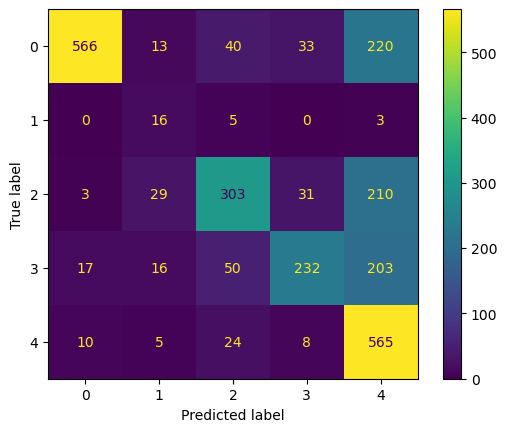

In [14]:
# Compute the confusion matrix for the test data predictions
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) #display_labels=label_encoder.classes_)
disp.plot()

Conclusions for the model: 

Accuracy: The overall accuracy of the model is 65%. This means that 65% of the predictions made by the model are correct.

For the Animalia kingdom there is a high precision but relatively lower recall. The model is very good at predicting the positive instances of Animalia but misses quite a few actual instances.

Very low precision for Archaea but high recall. The model often predicts Archaea when it is not, but it is able to capture most of the actual Archaea instances.

Fairly balanced precision and recall for Bacteria, but both are moderate. The model has a decent but not outstanding ability to predict this kingdom

Good precision but lower recall for Plantae. The model predicts  correctly when it does, but misses more than half of the actual Plantae instances.

Lower precision but very high recall for the kingdom Virus Bact. The model captures most of the instances but also makes many false positives.

There is a clear trade-off between precision and recall in many classes, indicating that the model might be more tuned towards capturing as many instances as possible (high recall) at the expense of precision (more false positives).



## Logistic Regression


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

In [16]:
# Split the data into training and testing sets
X_1 = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_1= codon_df_clean['Kingdom']


X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X_1, y_1, test_size=0.2, random_state=34)

In [17]:
print(X_train_lg.shape)
print (y_train_lg.shape)

(10406, 66)
(10406,)


In [18]:
#We define a list of steps (estimators) for our pipeline.
estimators_lg = [('normalise', StandardScaler()), #removing the mean and scaling to unit variance
              ('reduce_dim', PCA()),
              ('lg', LogisticRegression(n_jobs=4, random_state=34, max_iter=10000))]

pipe_lg = Pipeline(estimators_lg)
print(pipe_lg)

Pipeline(steps=[('normalise', StandardScaler()), ('reduce_dim', PCA()),
                ('lg',
                 LogisticRegression(max_iter=10000, n_jobs=4,
                                    random_state=34))])


In [19]:
n_components = list(range(60, 65, 1))

# params for LogisticRegression()
# C values
C = [0.001, 0.01, 0.1, 1, 10, 100] 

#define the parameter grid
params_lg = dict(
    reduce_dim__n_components = n_components,
    lg__C = C,
)
print(f"parameter grid values: {params_lg}")

parameter grid values: {'reduce_dim__n_components': [60, 61, 62, 63, 64], 'lg__C': [0.001, 0.01, 0.1, 1, 10, 100]}


In [20]:
#GridSearchCV to search for the best hyperparameters for the pipeline
grid_search_lg = GridSearchCV(pipe_lg, param_grid=params_lg, cv=5, scoring='accuracy')

#fit the GridSearchCV object to the training data
grid_search_lg.fit(X_train_lg, y_train_lg)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('reduce_dim', PCA()),
                                       ('lg',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=4,
                                                           random_state=34))]),
             param_grid={'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'reduce_dim__n_components': [60, 61, 62, 63, 64]},
             scoring='accuracy')

In [21]:
best_model = grid_search_lg.best_estimator_
print(grid_search_lg.best_estimator_.get_params()['reduce_dim__n_components'])
print(grid_search_lg.best_estimator_.get_params()['lg__C'])
print(best_model)

63
1
Pipeline(steps=[('normalise', StandardScaler()),
                ('reduce_dim', PCA(n_components=63)),
                ('lg',
                 LogisticRegression(C=1, max_iter=10000, n_jobs=4,
                                    random_state=34))])


The grid search process identified the following optimal parameters:

PCA: n_components=50, which balances the trade-off between retaining variance and reducing dimensionality.

Logistic Regression:
C=10, indicating less regularization and allowing a closer fit to the training data.

This configuration is expected to improve model accuracy and efficiency based on the results of the grid search.

In [22]:
#The optimized logistic regression model is instantiated with the following parameters
log_model_tunned = LogisticRegression(C=1, max_iter=10000, random_state=34)
log_model_tunned.fit(X_train_lg, y_train_lg)

LogisticRegression(C=1, max_iter=10000, random_state=34)

In [23]:
#model is then fitted to the training data
y_train_pred_lg = log_model_tunned.predict(X_train_lg)
y_test_pred_lg = log_model_tunned.predict(X_test_lg)

In [24]:
train_accuracy = accuracy_score(y_train_lg, y_train_pred_lg)
print(train_accuracy)

0.6266576974822218


In [25]:
test_accuracy = accuracy_score(y_test_lg, y_test_pred_lg)
print(test_accuracy)

0.6421983089930823


In [26]:
from sklearn.metrics import classification_report
report_train = classification_report(y_train_lg, y_train_pred_lg)
print(report_train)


                     precision    recall  f1-score   support

           animalia       0.97      0.61      0.75      3517
            archaea       0.00      0.00      0.00       102
           bacteria       0.56      0.64      0.60      2343
            plantae       0.88      0.38      0.53      2005
virus_bacteriophage       0.45      0.87      0.60      2439

           accuracy                           0.63     10406
          macro avg       0.57      0.50      0.49     10406
       weighted avg       0.73      0.63      0.63     10406



c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
report_test = classification_report(y_test_lg, y_test_pred_lg)
print(report_test)

                     precision    recall  f1-score   support

           animalia       0.96      0.63      0.76       872
            archaea       0.00      0.00      0.00        24
           bacteria       0.56      0.66      0.60       576
            plantae       0.88      0.40      0.55       518
virus_bacteriophage       0.48      0.88      0.62       612

           accuracy                           0.64      2602
          macro avg       0.58      0.51      0.51      2602
       weighted avg       0.74      0.64      0.64      2602



c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


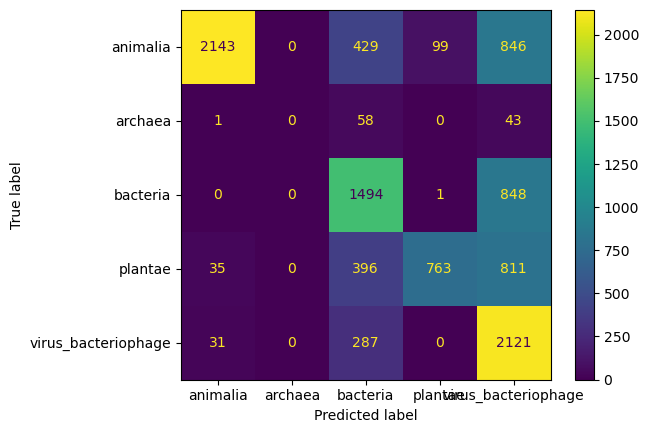

In [28]:
cm = confusion_matrix(y_train_lg, y_train_pred_lg)
ConfusionMatrixDisplay.from_estimator(log_model_tunned, X_train_lg, y_train_lg)

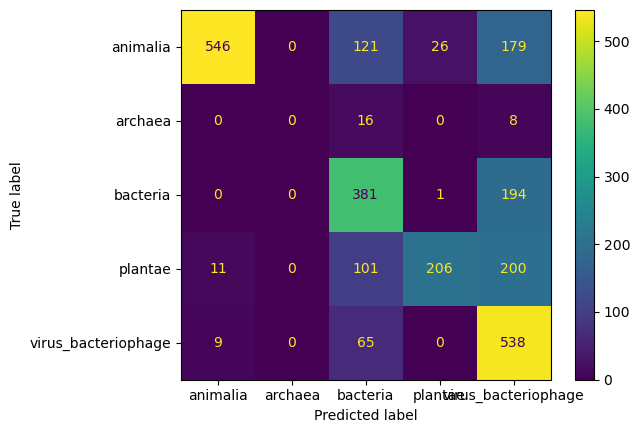

In [29]:
cm = confusion_matrix(y_test_lg, y_test_pred_lg)
ConfusionMatrixDisplay.from_estimator(log_model_tunned, X_test_lg, y_test_lg)



The overall accuracy of the model is 66%. This means that 66% of the predictions made by the model are correct.

High precision and moderate recall for Animalia. The model is good at predicting the kingdom but misses some actual instances.

The model completely fails to predict Archaea. This could be due to the very small sample size, leading to poor learning for this class.

Balanced but moderate precision and recall for Bacteria. The model performs reasonably well for this kingdom.

High precision but low recall for Plantae. The model correctly identifies Plantae instances but misses a significant number of them.

Moderate precision and high recall for Virus and Bacteriophage. The model captures most the instances but has a considerable number of false positives.

Logistic regression with PCA (66%) performs slightly better than Gaussian Naive Bayes (65%).

The logistic regression model fails to predict Archaea. This might be improved by handling class imbalance (e.g.,  a techniques like SMOTE) 


### Logistic Regresion without PCA components

In [30]:
X_lg = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_lg= codon_df_clean['Kingdom']


X_train_lgw, X_test_lgw, y_train_lgw, y_test_lgw = train_test_split(X_lg, y_lg, test_size=0.2, random_state=34)

In [31]:
scaler_LG = StandardScaler()

scaler_LG.fit(X_train_lgw)

X_train_scaled_lg = scaler_LG.transform(X_train_lgw)
X_test_scaled_lg = scaler_GNB.transform(X_test_lgw)

In [32]:
log_model_no_pca = LogisticRegression(max_iter=1000, random_state=34)
log_model_no_pca.fit(X_train_scaled_lg, y_train_lgw)

LogisticRegression(max_iter=1000, random_state=34)

In [33]:
y_train_pred_lg_1 = log_model_no_pca.predict(X_train_scaled_lg)
y_test_pred_lg_1 = log_model_no_pca.predict(X_test_scaled_lg)

In [34]:
test_accuracy_1 = accuracy_score(y_test_lgw, y_test_pred_lg_1)
print(test_accuracy_1)

0.9023827824750192


In [35]:
report_test_no_pca = classification_report(y_test_lgw, y_test_pred_lg_1)
print(report_test_no_pca)

                     precision    recall  f1-score   support

           animalia       0.91      0.90      0.91       872
            archaea       0.83      0.79      0.81        24
           bacteria       0.94      0.95      0.94       576
            plantae       0.87      0.85      0.86       518
virus_bacteriophage       0.88      0.91      0.89       612

           accuracy                           0.90      2602
          macro avg       0.89      0.88      0.88      2602
       weighted avg       0.90      0.90      0.90      2602



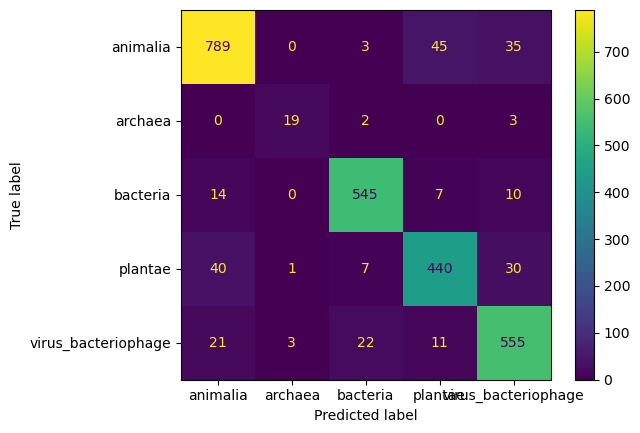

In [36]:
cm1 = confusion_matrix(y_test_lgw, y_test_pred_lg_1)
ConfusionMatrixDisplay.from_estimator(log_model_no_pca, X_test_scaled_lg, y_test_lgw)


This new classification report for the logistic regression model without PCA and with a standard scaler and default regularization strength (C) shows a significant improvement in performance compared to the previous models.The overall accuracy of the model is 90%. This is a substantial improvement. 

The model is very effective at predicting Animalia with very few false positives or false negatives.

Significant improvement in predicting 'Archaea'. Although the sample size is small, the model performs well with good precision and recall.

Well performance with very high precision and recall for Bacteria. The model is highly reliable for predicting this kingdom.

High precision and recall, indicating that the model predicts Plantae accurately and misses very few actual instances.

High precision and recall for Virus, showing that the model is very effective at predicting this class with minimal errors.

The removal of PCA and use of only a standard scaler has resulted in a substantial improvement. This suggests that PCA might have been discarding important features or introducing noise.Also, the model with standard scaling is able to handle class imbalances more effectively.


## KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
X_2 = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_2= codon_df_clean['Kingdom']


X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_2, y_2, test_size=0.2, random_state=34)

In [39]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [40]:
grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=4, scoring='accuracy')
grid_search_knn.fit(X_train_knn, y_train_knn)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 10],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [41]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [42]:
knn_model_tunned = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn_model_tunned.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [43]:
y_pred_test = knn_model_tunned.predict(X_test_knn)
y_pred_train = knn_model_tunned.predict(X_train_knn)

In [44]:
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.47886241352805536


In [45]:
report_train = classification_report(y_train_knn, y_pred_train)
print(report_train)

                     precision    recall  f1-score   support

           animalia       1.00      1.00      1.00      3517
            archaea       1.00      1.00      1.00       102
           bacteria       1.00      1.00      1.00      2343
            plantae       1.00      1.00      1.00      2005
virus_bacteriophage       1.00      1.00      1.00      2439

           accuracy                           1.00     10406
          macro avg       1.00      1.00      1.00     10406
       weighted avg       1.00      1.00      1.00     10406



In [46]:
report_test = classification_report(y_test_knn, y_pred_test)
print(report_test)

                     precision    recall  f1-score   support

           animalia       0.59      0.59      0.59       872
            archaea       0.04      0.04      0.04        24
           bacteria       0.43      0.43      0.43       576
            plantae       0.42      0.38      0.40       518
virus_bacteriophage       0.44      0.47      0.45       612

           accuracy                           0.48      2602
          macro avg       0.38      0.38      0.38      2602
       weighted avg       0.48      0.48      0.48      2602



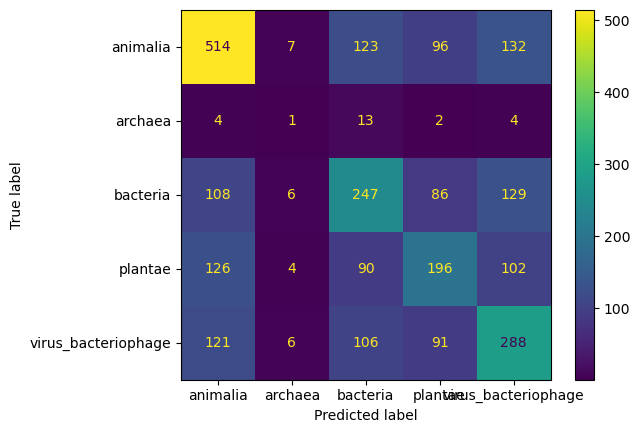

In [47]:
cm_test = confusion_matrix(y_test_knn, y_pred_test)
ConfusionMatrixDisplay.from_estimator(knn_model_tunned, X_test_knn, y_test_knn)


The overall accuracy of the model is 48%. This is significantly lower than the previous logistic regression model.

Moderate precision and recall for Animalia. The model correctly predicts this instances about half of the time.
Very poor performance for Archaea, with almost no correct predictions similar for Bacteria, Plantae and Virus Bact. 

The KNN model's accuracy (48%) is significantly lower than the logistic regression model without PCA (90%) and even lower than the logistic regression with PCA (66%) and Gaussian Naive Bayes (65%).

The KNN model with the current hyperparameters is underperforming compared to logistic regression models. Significant tuning or a different modeling approach is needed to achieve better classification performance. The logistic regression model without PCA remains the best performer among the models tried so far.



## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
X_3 = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_3= codon_df_clean['Kingdom']


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_3, y_3, test_size=0.2, random_state=34)

In [50]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=34))
])

In [51]:
param_grid_rf = {
    'pca__n_components': [40, 45],
    'rf__n_estimators': [200, 300, 350],
    'rf__max_depth': [30, 35],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

In [52]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=4, scoring='accuracy')
grid_search_rf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rf',
                                        RandomForestClassifier(random_state=34))]),
             n_jobs=4,
             param_grid={'pca__n_components': [40, 45],
                         'rf__max_depth': [30, 35],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [200, 300, 350]},
             scoring='accuracy')

In [53]:
# 20 minutes 
print("Best parameters found: ", grid_search_rf.best_params_)

Best parameters found:  {'pca__n_components': 45, 'rf__max_depth': 35, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


In [54]:
rf_model_tunned = RandomForestClassifier(random_state=34, n_estimators=300, max_depth=35, min_samples_leaf=1, min_samples_split=2)
rf_model_tunned.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=35, n_estimators=300, random_state=34)

In [55]:
best_pipeline_rf = grid_search_rf.best_estimator_
y_pred_rf = best_pipeline_rf.predict(X_test_rf)

In [56]:
print("Classification Test Report:")
print(classification_report(y_test_rf, y_pred_rf))
print("Accuracy Score:", accuracy_score(y_test_rf, y_pred_rf))

Classification Test Report:
                     precision    recall  f1-score   support

           animalia       0.95      0.95      0.95       872
            archaea       1.00      0.46      0.63        24
           bacteria       0.92      0.97      0.95       576
            plantae       0.94      0.90      0.92       518
virus_bacteriophage       0.93      0.94      0.94       612

           accuracy                           0.94      2602
          macro avg       0.95      0.84      0.88      2602
       weighted avg       0.94      0.94      0.94      2602

Accuracy Score: 0.9381245196003074


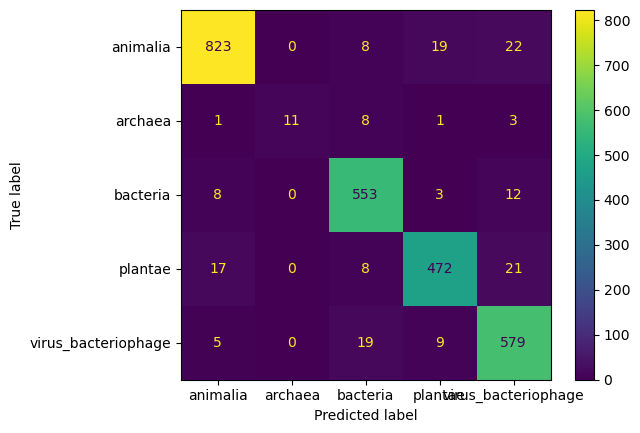

In [57]:
rf_test = confusion_matrix(y_test_rf, y_pred_rf)
ConfusionMatrixDisplay.from_estimator(rf_model_tunned, X_test_rf, y_test_rf)


The overall accuracy of the model is 94%. This is the highest accuracy achieved so far. 

Very high precision and recall for Animalia. The model is extremely effective at predicting them with minimal errors.

100 % precision but relatively low recall for Archaea. The model predicts their instances very accurately when it does, but it misses more than half of the actual instances, possibly due to the small sample size.

The model is highly reliable for predicting Bacteria.

High precision and recall, indicating that the model predicts Plantae and Virus Bact accurately with minimal errors.

The Random Forest model's accuracy (94%) is higher than the logistic regression model without PCA (90%) and significantly higher than the logistic regression with PCA (66%), Gaussian Naive Bayes (65%), and KNN (48%).

The use of PCA with 45 components in combination with Random Forest appears effective, suggesting that PCA helps in capturing the most informative features for this model.

The model performs well across all classes, though Archaea still presents a challenge. Investigating techniques to further improve recall for this class might be beneficial, such as oversampling or synthetic data generation mention before. 

In [58]:
from sklearn import tree
from sklearn.tree import plot_tree

In [59]:
best_rf = best_pipeline_rf.named_steps['rf']
n_components = best_pipeline_rf.named_steps['pca'].n_components_
feature_names = [f'PC{i+1}' for i in range(n_components)]
importances = best_rf.feature_importances_

In [60]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

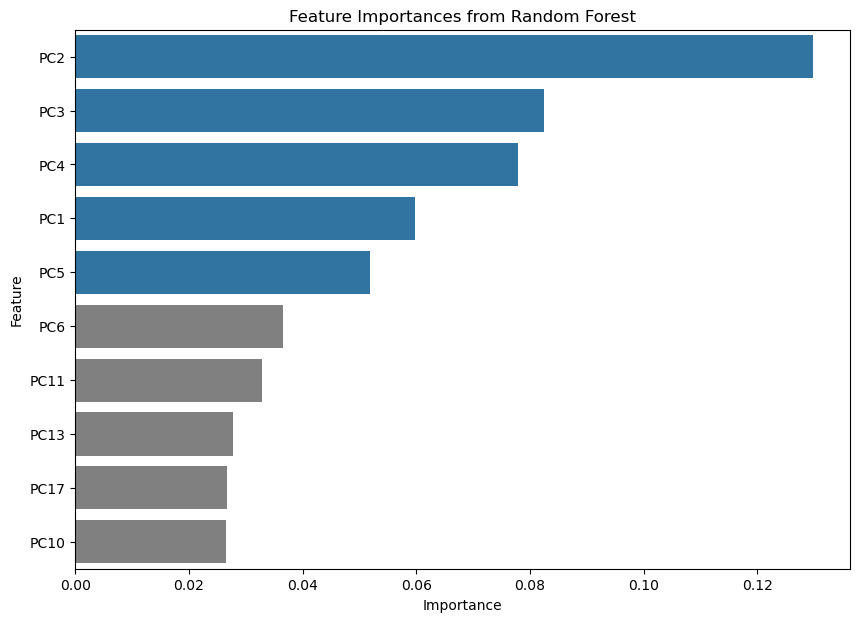

In [61]:
top_10_features = feature_importance_df.head(10)
palette = ['#1f77b4' if i < 5 else 'gray' for i in range(len(feature_importance_df))]
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette=palette)
plt.title('Feature Importances from Random Forest')
plt.show()

The feature importance analysis using PCA components indicates that the top five principal components (PCs) contributing to the classification task are PC2, PC3, PC4, PC1, and PC5. This information is useful for understanding which features (or combinations of features) are most influential in the model's decision-making process.

In [62]:
pca_rf = PCA(n_components=45)
pca_rf.fit(X_train_rf)
pca_rf.components_

array([[-6.11428303e-08,  1.00000000e+00, -1.00143230e-09, ...,
        -7.16317232e-11,  2.98638990e-12, -8.13801553e-10],
       [ 9.99114072e-01,  6.13207206e-08,  1.16866889e-02, ...,
         3.25809837e-04, -3.69332514e-05,  6.72403994e-03],
       [ 2.10342709e-02, -2.51958619e-09, -2.17254469e-01, ...,
        -5.85638210e-03, -3.47495338e-04,  3.32497778e-02],
       ...,
       [ 0.00000000e+00,  2.14548907e-11,  1.11516232e-01, ...,
         9.44093389e-03, -8.50234665e-03,  4.81356469e-02],
       [-0.00000000e+00,  5.62362221e-11, -1.75948411e-02, ...,
         3.15021705e-02,  9.81379871e-03,  1.02310660e-01],
       [ 0.00000000e+00,  8.17141363e-12,  7.72025884e-03, ...,
        -6.92632581e-02, -1.22429298e-02,  1.33863490e-01]])

Each principal component represents a linear combination of the original features. The importance of each PC indicates how much variance it explains in the data and how influential it is in making predictions.PC2, PC3, PC4, and PC5 might capture specific relationships between the original features that are more directly relevant to distinguishing between the biological kingdoms.

In [63]:
loadings = pca_rf.components_
loadings_df = pd.DataFrame(loadings, columns=X_train_rf.columns)

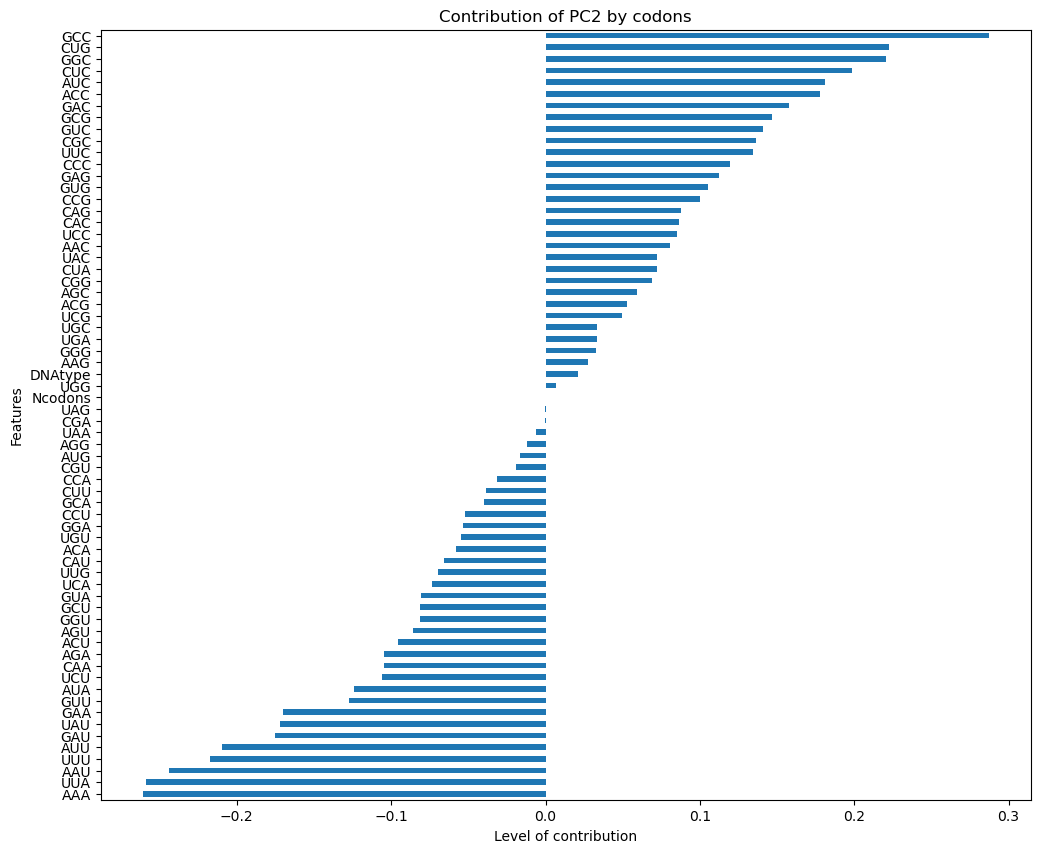

In [64]:
plt.figure(figsize=(12,10))
loadings_df.iloc[2, :].sort_values().plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Level of contribution')
plt.title('Contribution of PC2 by codons')
plt.show()

These represent how much each original feature (codon in this case) contributes to the principal component (PC2).

GCC: A contribution of almost 0.3 indicates that the codon GCC positively influences PC2. This means that samples with higher frequencies of the codon GCC are likely to have higher values along PC2.

AAA: A contribution of approximately -2.5 suggests that the codon AAA negatively influences PC2. Samples with higher frequencies of AAA are likely to have lower values along PC2.

The absolute value of the contribution (0.3 for GCC and 2.5 for AAA) indicates the strength of influence each codon has on shaping PC2. Larger absolute values indicate stronger influence.

Understanding the contributions of codons like GCC and AAA to PC2 provides valuable insights into how these biological markers are utilized in your classification model. This knowledge not only aids in model interpretation and refinement but also enhances understanding of the underlying biological processes reflected in your data.

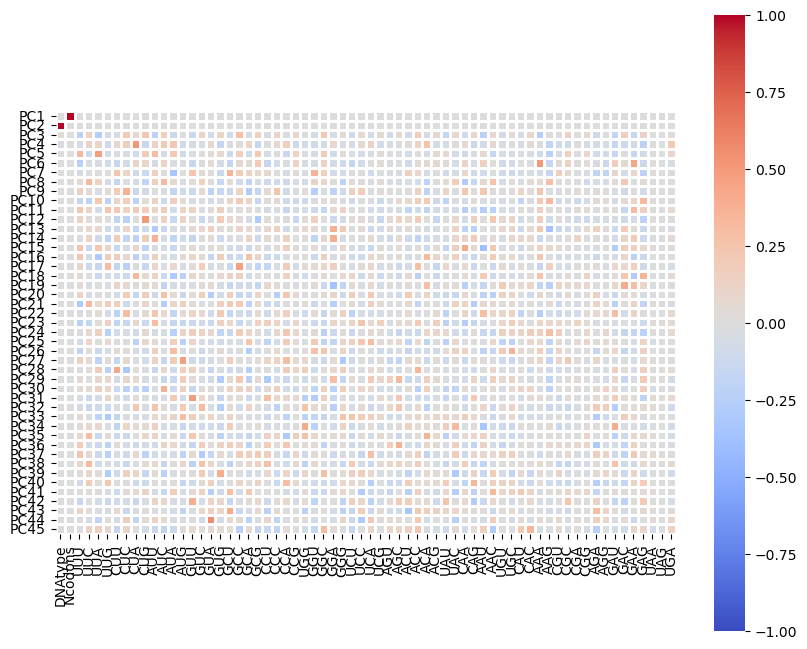

In [65]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(pca_rf.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PC"+str(x) for x in range(1,pca_rf.n_components_+1)],
                 xticklabels=list(X_train_rf.columns[:]),
                 linewidths = 1,
                 annot = False,
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_aspect("equal")
plt.show()

In [66]:
single_tree = best_rf.estimators_[0]

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=900)
plot_tree(single_tree, 
          feature_names=feature_names, 
          class_names=[str(i) for i in np.unique(y_train_rf)], 
          filled=True, 
          rounded=True,
          impurity=True,
          max_depth=2)
plt.show()

### Desicion Tree without PCA

In [68]:
X_3_ = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_3_= codon_df_clean['Kingdom']


X_train_rf_1, X_test_rf_1, y_train_rf_1, y_test_rf_1 = train_test_split(X_3_, y_3_, test_size=0.2, random_state=34)

In [69]:
scaler_RDF = StandardScaler()

scaler_RDF.fit(X_train_rf_1)

X_train_scaled_rf = scaler_RDF.transform(X_train_rf_1)
X_test_scaled_rf = scaler_RDF.transform(X_test_rf_1)

In [70]:
rf_model = RandomForestClassifier(random_state=34, n_estimators=300, max_depth=35, min_samples_leaf=1, min_samples_split=2)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=35, n_estimators=300, random_state=34)

In [71]:
y_pred_rf_1 = rf_model.predict(X_test_scaled_rf)

c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [72]:
accuracy_rf = accuracy_score(y_test_rf_1, y_pred_rf_1)
print(f'Accuracy: {accuracy_rf:.2f}')

Accuracy: 0.74


In [73]:
report_rf = classification_report(y_test_rf_1, y_pred_rf_1)
print(report_rf)

                     precision    recall  f1-score   support

           animalia       0.72      0.89      0.80       872
            archaea       1.00      0.17      0.29        24
           bacteria       0.73      0.95      0.83       576
            plantae       0.71      0.77      0.74       518
virus_bacteriophage       0.92      0.32      0.47       612

           accuracy                           0.74      2602
          macro avg       0.82      0.62      0.62      2602
       weighted avg       0.77      0.74      0.71      2602



The overall accuracy of the model is 74%, indicating it correctly predicts 74% of the instances in the test set.

Moderate precision but high recall for Animalia, indicating that while the model predicts Animalia instances well, there are some false positives.

100% precision but very low recall for Archaea, suggesting that while the model rarely misclassifies Archaea, it misses most of the actual instances.

High recall with moderate precision for Bacteria, indicating effective prediction with some false positives.

Balanced precision and recall for Plantae, suggesting consistent performance in predicting this class.

High precision but low recall for Virus Bacteriophage, indicating that while the model correctly identifies instances of this class, it misses many actual instances.

The Random Decision Tree model's accuracy (74%) is higher than KNN (48%) but lower than Random Forest (94%) and logistic regression without PCA (90%).

Inspect feature importance, which tells which features were most influential in making predictions.

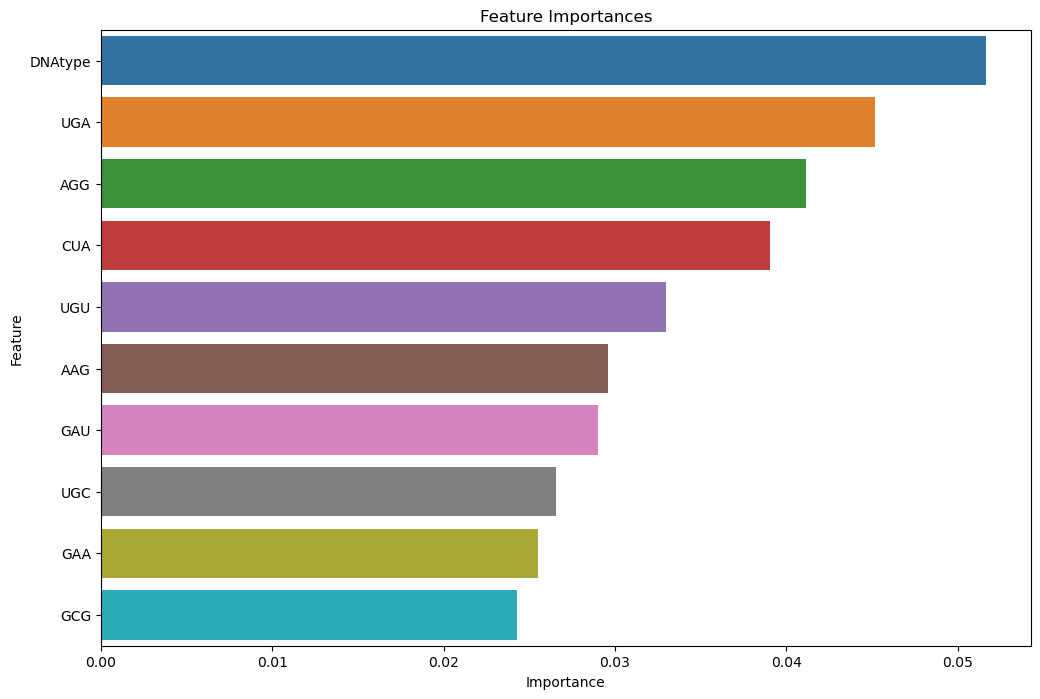

In [74]:
feature_importances = rf_model.feature_importances_
feature_names = X_3_.columns

# Creating a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()

The high importance of DNA type indicates that variations in DNA sequences play a critical role in classifying biological kingdoms. Different types of DNA sequences likely correlate with different biological characteristics that the model uses to make classifications.

Specific codons like UGA, AGG, CUA, and UGU are identified as key features. These codons are known to be important in genetic coding and may have significant biological implications that the model leverages for accurate predictions.

## Clustering

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [76]:
codon_df_scaled = codon_df_clean.drop(columns=['Kingdom', 'SpeciesID', 'Ncodons', 'SpeciesName','DNAtype'])
codon_df_scaled

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,0.03920,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,0.06386,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,0.06643,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,0.02082,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


I know that our target is divide by 10 classes. So as a test lets explore if using k as 10 will shown 10 clusters 

In [77]:
kmeans1 = KMeans(n_clusters= 10)
kmeans1_labels = kmeans1.fit_predict(codon_df_scaled)

agg1 = AgglomerativeClustering(n_clusters = 10 , linkage='ward')
agg1_labels = agg1.fit_predict(codon_df_scaled)

gmm1 = GaussianMixture(n_components = 10)
gmm1_labels = gmm1.fit_predict(codon_df_scaled)

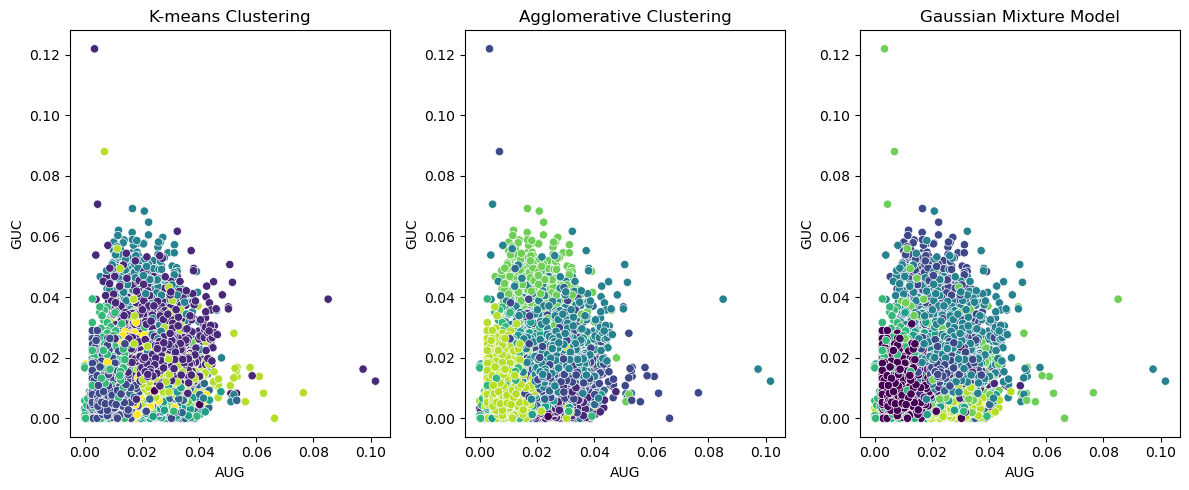

In [78]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='AUG', y='GUC', hue=kmeans1_labels, palette='viridis', data=codon_df_scaled, legend=False)
plt.title('K-means Clustering')


plt.subplot(1, 3, 2)
sns.scatterplot(x='AUG', y='GUC', hue=agg1_labels, palette='viridis', data=codon_df_scaled, legend=False)
plt.title('Agglomerative Clustering')


plt.subplot(1, 3, 3)
sns.scatterplot(x='AUG', y='GUC', hue=gmm1_labels, palette='viridis', data=codon_df_scaled, legend=False)
plt.title('Gaussian Mixture Model')

plt.tight_layout()
plt.show()

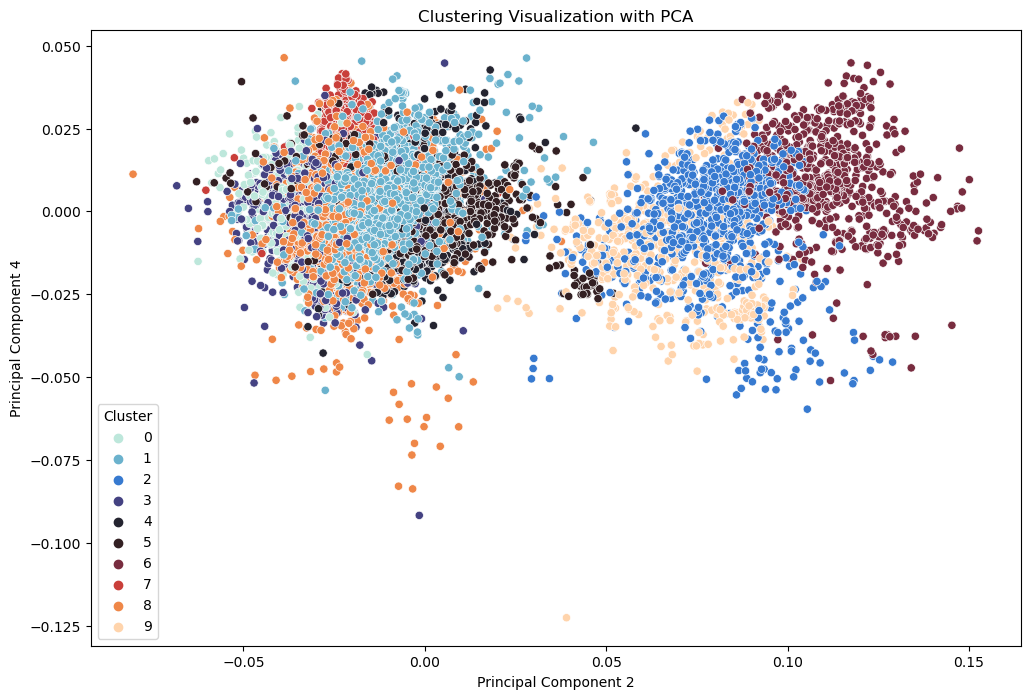

In [79]:
pca_clustering = PCA(n_components=10)
principal_components = pca_clustering.fit_transform(codon_df_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:, 1], y=principal_components[:, 5], hue=kmeans1_labels, palette='icefire', legend='full')
plt.title('Clustering Visualization with PCA')

plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')
plt.legend(title='Cluster', loc='best')

plt.show()

c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


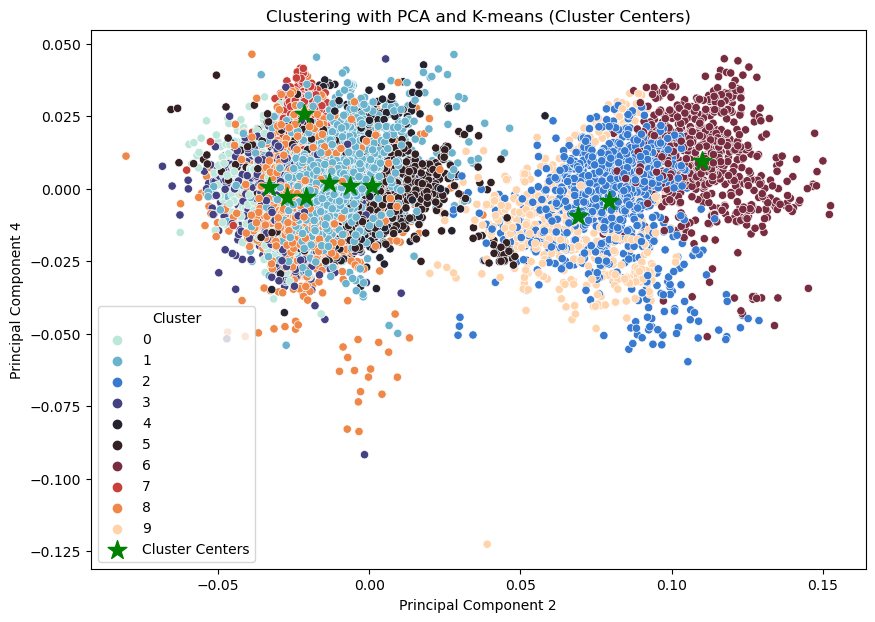

In [80]:
cluster_centers_pca = pca_clustering.transform(kmeans1.cluster_centers_)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=principal_components[:, 1], y=principal_components[:, 5], hue=kmeans1_labels, palette='icefire', legend='full')
plt.scatter(cluster_centers_pca[:, 1], cluster_centers_pca[:, 5], marker='*', color='green', s=200, label='Cluster Centers')
plt.title('Clustering with PCA and K-means (Cluster Centers)')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')
plt.legend(title='Cluster', loc='best')
plt.show()

In [81]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [82]:
silhouette_avg_kmeans = silhouette_score(codon_df_scaled, kmeans1_labels)
print(f"Silhouette Score for K-means clustering: {silhouette_avg_kmeans}")

silhouette_avg_agg = silhouette_score(codon_df_scaled, agg1_labels)
print(f"Silhouette Score for Agglomerative clustering: {silhouette_avg_agg}")

silhouette_avg_gmm = silhouette_score(codon_df_scaled, gmm1_labels)
print(f"Silhouette Score for Gaussian Mixture clustering: {silhouette_avg_gmm}")


Silhouette Score for K-means clustering: 0.1421795380900733
Silhouette Score for Agglomerative clustering: 0.12462036478294249
Silhouette Score for Gaussian Mixture clustering: 0.09303207906805637


The differences in silhouette scores between these methods are relatively small, indicating that all three algorithms perform similarly on your dataset in terms of clustering quality based on silhouette analysis.

In [83]:
from sklearn.metrics import rand_score

In [84]:
print(f'This is the rand score for kmeans and agg {rand_score(kmeans1_labels, agg1_labels)}')
print(f'This is the rand score for kmeans and gmm {rand_score(kmeans1_labels, gmm1_labels)}')

This is the rand score for kmeans and agg 0.8774207090306468
This is the rand score for kmeans and gmm 0.8504418119640564


The Rand score of approximately 0.87 and 0.85 indicates a high level of agreement or similarity between the clusterings produced by K-means and Agglomerative Clustering and K-means and Gaussian Mixture Model. This suggests that the two clustering algorithms data points to clusters in a very similar manner.

Using k=10 didnt shown 10 clusters therefore lets find the best k for this dataset

In [85]:
silScoreKmeans = []
silScoresGauss =[]
silScoresAgglom =[]

ks = np.arange(2,11)

for k in ks:

    print(f'currently working on kmeans with k={k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(codon_df_scaled)
    kmeans_score = silhouette_score(codon_df_scaled, kmeans.labels_)
    silScoreKmeans.append(kmeans_score)

    print(f'currently working on gmm with k={k}')
    gmm = GaussianMixture(n_components=k)
    gmm.fit(codon_df_scaled)
    gmm_score = silhouette_score(codon_df_scaled, gmm.predict(codon_df_scaled))
    silScoresGauss.append(gmm_score)

    #fit hierarchichal (agglomerative)
    print(f'currently working on agg with k={k}')
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(codon_df_scaled)
    agg_score = silhouette_score(codon_df_scaled, agg.labels_)
    silScoresAgglom.append(agg_score)

currently working on kmeans with k=2
currently working on gmm with k=2
currently working on agg with k=2
currently working on kmeans with k=3
currently working on gmm with k=3
currently working on agg with k=3
currently working on kmeans with k=4
currently working on gmm with k=4
currently working on agg with k=4
currently working on kmeans with k=5
currently working on gmm with k=5
currently working on agg with k=5
currently working on kmeans with k=6
currently working on gmm with k=6
currently working on agg with k=6
currently working on kmeans with k=7
currently working on gmm with k=7
currently working on agg with k=7
currently working on kmeans with k=8
currently working on gmm with k=8
currently working on agg with k=8
currently working on kmeans with k=9
currently working on gmm with k=9
currently working on agg with k=9
currently working on kmeans with k=10
currently working on gmm with k=10
currently working on agg with k=10


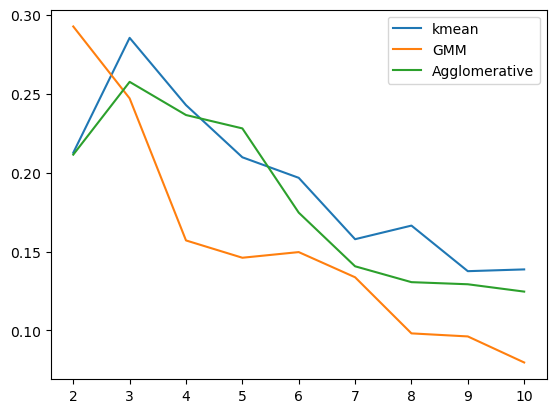

In [86]:
plt.figure()
plt.plot(ks, silScoreKmeans, label='kmean')
plt.plot(ks, silScoresGauss, label='GMM')
plt.plot(ks, silScoresAgglom, label='Agglomerative')
plt.legend()
plt.show()

In [87]:
kmeans2 = KMeans(n_clusters=3)
kmeans2_labels = kmeans2.fit_predict(codon_df_scaled)

agg2 = AgglomerativeClustering(n_clusters = 3, linkage='ward')
agg2_labels = agg2.fit_predict(codon_df_scaled)

gmm2 = GaussianMixture(n_components = 3)
gmm2_labels = gmm2.fit_predict(codon_df_scaled)

In [88]:
silhouette_avg_kmeans2 = silhouette_score(codon_df_scaled, kmeans2_labels)
print(f"Silhouette Score for K-means clustering: {silhouette_avg_kmeans2}")

silhouette_avg_agg2 = silhouette_score(codon_df_scaled, agg2_labels)
print(f"Silhouette Score for Agglomerative clustering: {silhouette_avg_agg2}")

silhouette_avg_gmm2 = silhouette_score(codon_df_scaled, gmm2_labels)
print(f"Silhouette Score for Gaussian clustering: {silhouette_avg_gmm2}")

Silhouette Score for K-means clustering: 0.28467730005977565
Silhouette Score for Agglomerative clustering: 0.2574084513816836
Silhouette Score for Gaussian clustering: 0.2469441764394765


In [89]:
print(f'This is the rand score with k= 3 for kmeans and agg: {rand_score(kmeans2_labels, agg2_labels)}')
print(f'This is the rand score with k= 3 for kmeans and gaussina: {rand_score(kmeans2_labels, gmm2_labels)}')

This is the rand score with k= 3 for kmeans and agg: 0.7201041855501972
This is the rand score with k= 3 for kmeans and gaussina: 0.8101418755403822


The Rand index score of 0.7151 for K-means and Agglomerative Clustering (agg) with k=3 indicates a high level of agreement between the clusterings

## XGBOOST

In [90]:
from xgboost import XGBClassifier

In [91]:
X_xgb = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName', 'SpeciesID'])
y_xgb = codon_df_clean['Kingdom']


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=34)

In [92]:
scaler_xgb = StandardScaler()
X_train_xgb_scaled = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler_xgb.transform(X_test_xgb)

In [93]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_xgb_scaled, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
y_pred_xgb = xgb_model.predict(X_test_xgb_scaled)
print(classification_report(y_test_xgb, y_pred_xgb))

                     precision    recall  f1-score   support

           animalia       0.96      0.97      0.96       872
            archaea       0.93      0.58      0.72        24
           bacteria       0.95      0.96      0.96       576
            plantae       0.96      0.93      0.94       518
virus_bacteriophage       0.94      0.96      0.95       612

           accuracy                           0.95      2602
          macro avg       0.95      0.88      0.91      2602
       weighted avg       0.95      0.95      0.95      2602



In [95]:
print(f"XG Boost score: {xgb_model.score(X_test_xgb_scaled, y_test_xgb)}")

XG Boost score: 0.9523443504996156


The overall accuracy of the XGBoost model is 95%.

Very high precision and recall for Animalia, indicating excellent prediction performance with minimal errors.

High precision but lower recall for Archaea, indicating accurate predictions when the model identifies them but misses some instances due to the small sample size.

High precision and recall for Bacteria, suggesting solid performance in predicting this class.

Very high precision and recall for Plantae, indicating accurate predictions with minimal errors.

High precision and recall for Virus Bacteriophage, suggesting effective classification performance.

The XGBoost model's accuracy (95%) is the highest among all the models tested, indicating superior overall performance.


In [96]:
cv_scores = cross_val_score(XGBClassifier(), X_xgb, y_xgb, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.84089162 0.93658724 0.96733282 0.95847751 0.88389081]
Mean cross-validation score: 0.9174360006394986


The cross-validation scores obtained for your XGBoost model indicate its consistency and reliability across different folds of our dataset. 

In other words the high mean score indicates that the XGBoost model is likely to generalize well to new, unseen data from the same distribution.

In [97]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [98]:
ensemble_model = VotingClassifier(estimators=[
    ('xgb', XGBClassifier()),
    ('lr', LogisticRegression(max_iter=1000)),
    ('svc', SVC())
], voting='hard')

ensemble_model.fit(X_train_xgb_scaled, y_train_xgb)
print(f"Ensemble model score: {ensemble_model.score(X_test_xgb_scaled, y_test_xgb)}")

y_pred_ensemble = ensemble_model.predict(X_test_xgb_scaled)
print(classification_report(y_test_xgb, y_pred_ensemble))

Ensemble model score: 0.9496541122213682
                     precision    recall  f1-score   support

           animalia       0.96      0.96      0.96       872
            archaea       1.00      0.67      0.80        24
           bacteria       0.95      0.97      0.96       576
            plantae       0.96      0.92      0.94       518
virus_bacteriophage       0.93      0.95      0.94       612

           accuracy                           0.95      2602
          macro avg       0.96      0.89      0.92      2602
       weighted avg       0.95      0.95      0.95      2602



The ensemble model’s performance (95% accuracy) is comparable to or slightly better than the individual models (XGBoost, Logistic Regression, SVC) previously tested.

The ensemble approach combines the strengths of multiple models, often resulting in improved overall performance compared to individual models.

Given the high accuracy and balanced metrics across classes, the ensemble model appears robust and reliable for classifying biological kingdoms based on codon frequencies.

## Conclusion

######### missing clustering conclusion ########

1 - Gaussian Naive Bayes: Achieved an accuracy of 65% with moderate precision and recall across classes. It served as a baseline model for comparison.

2 - Logistic Regression: Achieved accuracies ranging from 65% to 90% depending on the configuration, with noticeable improvements when using PCA for dimensionality reduction.

3 - K-Nearest Neighbors (KNN): Had an accuracy of 48%, indicating less effective performance compared to other models, possibly due to the high-dimensional feature space.

4 - Random Forest: Demonstrated strong performance with an accuracy of 94%, high precision, recall, and F1-scores across classes, highlighting its effectiveness in handling complex relationships in the data.

5 - XGBoost: Stood out with the highest accuracy of 95%, consistently high precision, recall, and F1-scores across all classes, indicating robust and reliable performance.

6 -Ensemble Model (Voting Classifier): Combined the strengths of XGBoost, Logistic Regression, and SVC to achieve an accuracy of 95%, demonstrating balanced performance with high precision and recall across classes.

| Model                                 | Hyperparamethers                                                                                         | Score | Precision (Average) | Recall (Average) |
|---------------------------------------|----------------------------------------------------------------------------------------------------------|-------|---------------------|------------------|
| Gaussian Naive Bayes (baseline model) | Standar Scaler                                                                                           | 65%   | 62%                 | 64%              |
| Logistic Regression                   | PCA = 63  Standar Scaler C = 1 cv = 5                                                                    | 64%   | 58%                 | 51%              |
| Logistic Regression                   | StandarScaler                                                                                            | 90%   | 89%                 | 88%              |
| KNN                                   | StandarScaler n_neighbors = 3 weights = distance metric = manhattan cv = 5                               | 48%   | 38%                 | 38%              |
| Random Forest                         | StandarScaler PCA = 45 max_depth = 35  min_sample_leaf = 1 min_sample_split =2 n_estimators = 300 cv = 5 | 94%   | 95%                 | 84%              |
| Random Forest                         | StandarScaler n_estimators = 300 max_depth = 35 min_sample_leaf = 1                                      | 74%   | 82%                 | 62%              |
| XGBoost                               |                                                                                                          | 95%   | 95%                 | 88%              |
| Ensamble                              | XGBoost Logistic Regression SVC voting = hard                                                            | 95%   | 96%                 | 89%              |

In conclusion, the study highlights the efficacy of machine learning models, particularly XGBoost and ensemble methods, in accurately classifying biological kingdoms based on codon frequencies. These models not only offer high accuracy but also provide insights into biological markers influencing classification decisions.